# Titanic with Pandas and Scikit-Learn

* **Survived**: Survival (0 = no; 1 = yes)
* **Pclass**: Passenger class (1 = first; 2 = second; 3 = third)
* **Name**
* **Sex**
* **Age**
* **SibSp**: Number of siblings aboard
* **Parch**: Number of parents/children aboard
* **Ticket**: Ticket number
* **Fare**: Passenger fare
* **Cabin**
* **Embarked**: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## Data Exploration

First, import some useful modules

In [2]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # use seaborn, see https://stanford.edu/~mwaskom/software/seaborn/
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from collections import Counter

Load the training data set into a pandas data frame and see how many records are there and what is in the data

In [3]:
training_df = pd.read_csv("train.csv")
testing_df = pd.read_csv("test.csv")

Show first 5 rows of the data frame:

In [4]:
training_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Which of these variables could be important for predicting survival? We can safely get rid of the passenger ID (**PassengerId**) as it has nothing to do with anything except giving each passenger a unique identifier. Next, the **Name** variable. It's unlikely to be meaningful in terns of changes to drawn, so we can get rid of it. On the other hand, before we do it, let us extract titles and put them in a new column. We will use them later on. 
The ticket numbers (**Ticket**) are of questionable use too, unless we feel that some numbers could have been unlucky of something of that sort. For now, we choose to ignore this variable. **Cabin** could be important if we had a map of the ship or any interpretation of what the first letter of the cabin name means (perhaps, a particular location on the ship easier to get to a boat from). However, we don't have that information so can just ignore the cabin variable.

In [5]:
training_df["Title"]=training_df["Name"].apply(lambda _: _.split(",")[1].split(".")[0].strip()).astype(str)
tdf = training_df.drop(["PassengerId","Name","Ticket","Cabin"],axis=1)  # call a new smaller data frame tdf
Counter(tdf["Title"])

Counter({'Capt': 1,
         'Col': 2,
         'Don': 1,
         'Dr': 7,
         'Jonkheer': 1,
         'Lady': 1,
         'Major': 2,
         'Master': 40,
         'Miss': 182,
         'Mlle': 2,
         'Mme': 1,
         'Mr': 517,
         'Mrs': 125,
         'Ms': 1,
         'Rev': 6,
         'Sir': 1,
         'the Countess': 1})

In [6]:
same_as_mrs = ["Mrs","Mme","the Countess","Lady","Dona"]
same_as_mr = ["Capt","Col","Don","Mr","Jonkheer","Major","Master","Rev","Sir","Dr"]
same_as_ms = ["Ms","Miss","Mlle"]

tdf.loc[tdf["Title"].isin(same_as_mrs), "Title"] = "Mrs" 
tdf.loc[tdf["Title"].isin(same_as_mr), "Title"] = "Mr"
tdf.loc[tdf["Title"].isin(same_as_ms), "Title"] = "Ms"

Counter(tdf["Title"])

Counter({'Mr': 578, 'Mrs': 128, 'Ms': 185})

Make certain integers type float, just in case:

In [7]:
tdf["SibSp"] = tdf["SibSp"].astype(float)
tdf["Pclass"] = tdf["Pclass"].astype(float)
tdf.dtypes

Survived      int64
Pclass      float64
Sex          object
Age         float64
SibSp       float64
Parch         int64
Fare        float64
Embarked     object
Title        object
dtype: object

### A few plots to see what's going on

<IPython.core.display.Javascript object>


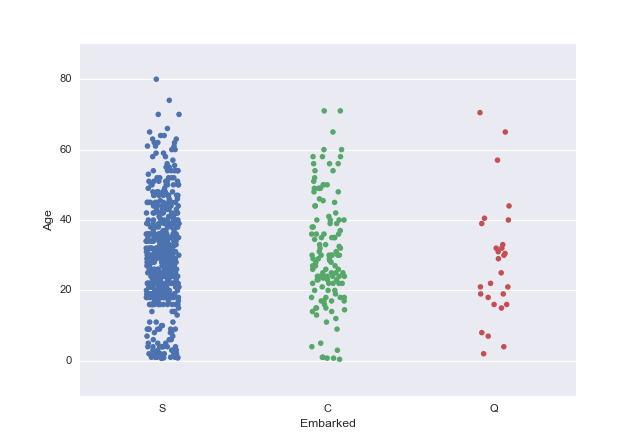

In [8]:
plt.figure()
sns.stripplot(x="Embarked", y="Age", data=tdf, jitter=True);

So, what's interesting about this? 
* There was only a few people over 60 on Titanic
* Not many children either
* Not many people embarked in Queenstown

<IPython.core.display.Javascript object>


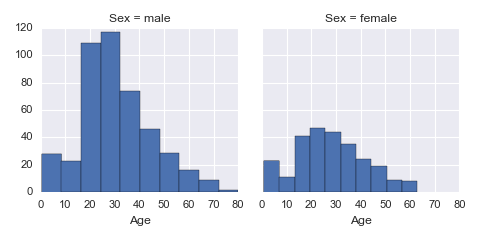

In [9]:
sns.FacetGrid(tdf, col="Sex").map(plt.hist, "Age")

Apparently, more males than females on board. Males were typically aged 20 to 40.

<IPython.core.display.Javascript object>


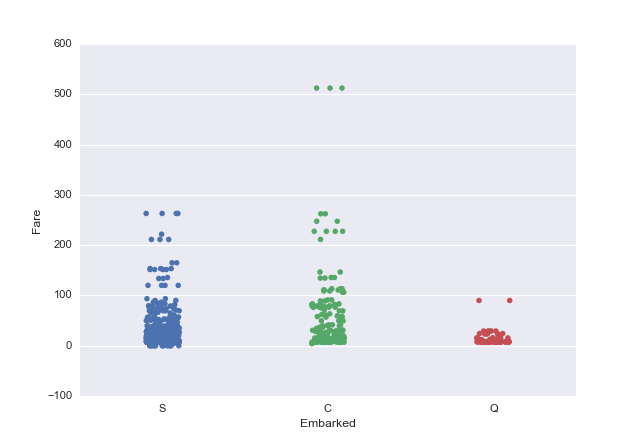

In [10]:
plt.figure()
sns.stripplot(x="Embarked", y="Fare",data=tdf, jitter=True);

We see that passengers that embarked in Queenstown bought the cheapest tickets except for 2 persons who paid nearly 100 pounds each.

## Missing Values

What to do about the missing values? Let's check how manuy of these we've got.

In [11]:
tdf.count()-len(tdf.index)  # this returns the number of missing observations in each column

Survived      0
Pclass        0
Sex           0
Age        -177
SibSp         0
Parch         0
Fare          0
Embarked     -2
Title         0
dtype: int64

All looks good except **Age**. And there are 2 values missing in **Embarked**. It's not obvious what we should do with **Embarked** and if it's important at all. However, we do need to deal with **Age**. We could just set all absent age values to 0 or ignore all records where age is not available. Or, we could approximate the age based on Title. How often do we see records with no age but some title present?

In [12]:
len(tdf[tdf["Age"].isnull() & tdf["Title"].notnull()].index)

177

Note that if we manage to approximate **Age** from **Title**, we will have 714+177=891 records with **Age**, i.e. we will fill in all the ages this way. Let's calculate average age depending on **Title**.

In [13]:
tdf.head(3)
aver_age_miss = round(tdf[~tdf["Age"].isnull()  & (tdf["Title"].str.strip().isin(["Miss","Ms"]))]["Age"].mean(),1)
print("average age for a Miss is {}".format(aver_age_miss))

average age for a Miss is 21.8


In [14]:
aver_age_mrs = round(tdf[~tdf["Age"].isnull()  & (tdf["Title"].str.strip().isin(["Mrs"]))]["Age"].mean(),1)
print("average age for a Mrs is {}".format(aver_age_mrs))

average age for a Mrs is 35.9


In [15]:
aver_age_mr = round(tdf[~tdf["Age"].isnull()  & (tdf["Title"].str.strip().isin(["Mr"]))]["Age"].mean(),1)
print("average age for a Mr is {}".format(aver_age_mr))

average age for a Mr is 30.8


Alright. Let us insert the substitutes for the missing Age values..

In [16]:




miss_idx = tdf["Title"].str.strip().isin(same_as_ms)
tdf.loc[miss_idx, "Age"] = tdf.loc[miss_idx, "Age"].fillna(aver_age_miss)
mr_idx = tdf["Title"].str.strip().isin(same_as_mr)
tdf.loc[mr_idx,"Age"] = tdf.loc[mr_idx,"Age"].fillna(aver_age_mr)
mrs_idx = tdf["Title"].str.strip().isin(same_as_mrs)
tdf.loc[mrs_idx,"Age"] = tdf.loc[mrs_idx,"Age"].fillna(aver_age_mrs)

tdf["Embarked"] = tdf["Embarked"].fillna(tdf["Embarked"].mode().loc[0])


## Prediction

Split training data into the training and testing datasets. We will only be using **Age**, **Siblings**, **Fare** and **Class** for prediction.

In [17]:
vars_for_prediction = ["Pclass","Sex","Age","SibSp","Parch","Embarked","Title"]

from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer(sparse=False)
# DictVectorizer expects data as a list of dictionaries, where each dictionary is a data 
# row with column names as keys; for example, 
# [ { 'director': 'M', 'budget': 25 }, { 'director': 'F', 'budget': 259 }, ...],
df_var = tdf[vars_for_prediction]
df_var_as_dict = df_var.T.to_dict().values()
df_var_vectorized_as_array = v.fit_transform(df_var_as_dict)  # returns an numpy array,
df_var_vectorized = pd.DataFrame(df_var_vectorized_as_array)
v.get_feature_names()

#X = tdf[['Age', 'SibSp', 'Fare','Pclass']].fillna(0)  # variables
y = tdf['Survived']  # outcome

X_train, X_test, y_train, y_test = train_test_split(df_var_vectorized, y, test_size=0.15, random_state=11)

### Logictic Regression

In [18]:
lr = LogisticRegression(penalty="l2")
lr.fit(X_train, y_train)

print(accuracy_score(y_test, lr.predict(X_test)))

0.865671641791


### Decision Tree

In [19]:
clf = tree.DecisionTreeClassifier(splitter="random",min_samples_leaf=0.25)
clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))



0.850746268657


### Naive Bayes

In [20]:
nbc = GaussianNB()
nbc.fit(X_train, y_train)
print(accuracy_score(y_test, nbc.predict(X_test)))

0.858208955224


### RandomForests

In [21]:
rf = RandomForestClassifier(n_estimators=13,max_features='sqrt', min_weight_fraction_leaf=0.02)
rf.fit(X_train, y_train)

print(accuracy_score(y_test, rf.predict(X_test)))

0.865671641791


## Extra Trees

In [57]:
xt = ExtraTreesClassifier(n_estimators=14, max_depth=None, min_samples_split=13, random_state=0)
xt.fit(X_train, y_train)
print(accuracy_score(y_test, xt.predict(X_test)))

0.880597014925


In [58]:


testing_df["Title"]=testing_df["Name"].apply(lambda _: _.split(",")[1].split(".")[0].strip()).astype(str)

testing_df.loc[tdf["Title"].isin(same_as_mrs), "Title"] = "Mrs" 
testing_df.loc[tdf["Title"].isin(same_as_mr), "Title"] = "Mr"
testing_df.loc[tdf["Title"].isin(same_as_ms), "Title"] = "Ms"


miss_idx = testing_df["Title"].str.strip().isin(same_as_ms)
testing_df.loc[miss_idx, "Age"] = testing_df.loc[miss_idx, "Age"].fillna(aver_age_miss)
mr_idx = testing_df["Title"].str.strip().isin(same_as_mr)
testing_df.loc[mr_idx,"Age"] = testing_df.loc[mr_idx,"Age"].fillna(aver_age_mr)
mrs_idx = testing_df["Title"].str.strip().isin(same_as_mrs)
testing_df.loc[mrs_idx,"Age"] = testing_df.loc[mrs_idx,"Age"].fillna(aver_age_mrs)

testing_df["Embarked"] = testing_df["Embarked"].fillna(testing_df["Embarked"].mode().loc[0])

testing_df.head()

df_var = testing_df[vars_for_prediction]
df_var_as_dict = df_var.T.to_dict().values()
df_var_vectorized_as_array = v.fit_transform(df_var_as_dict)  # returns an numpy array,
df_var_vectorized = pd.DataFrame(df_var_vectorized_as_array)
v.get_feature_names()

Y_pred = xt.predict(df_var_vectorized)  # note we use the RandomForests model here
print("predicted {} survival outcomes".format(len(Y_pred)))

predicted 418 survival outcomes


Format precistions for submission. Recall that we have to submit a .csv with 2 columns, PassengerID and Survived.

In [59]:
submission_df = pd.DataFrame(columns=["PassengerId","Survived"])
submission_df["PassengerId"] = testing_df["PassengerId"]
submission_df["Survived"] = Y_pred
submission_df.head()

# save this data frame to a .csv file
submission_df.to_csv("titanic_submission.csv",index=False)

This looks right. Next step - submit :)